In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def poly(params,x):
    return tf.reshape(tf.reduce_sum(tf.multiply(x ** np.linspace(0,degree-1,degree), params),axis = 1),[-1,1])

def poly2(params,xx):
    exp = np.linspace(0,3-1,3).reshape(1,-1)
    yy = np.sum((xx.reshape(-1,1) ** exp)*params,1)
    return yy


In [3]:
# Polynomial degree
degree = 3
n_train = 100
n_test = 1
n_hidden = 20

# Generate Training Data
f_train = np.random.uniform(size=(n_train,3),high=10)
x_init = 0.5*np.ones((n_train,1))
h_init = np.random.uniform(size=(n_train,n_hidden))

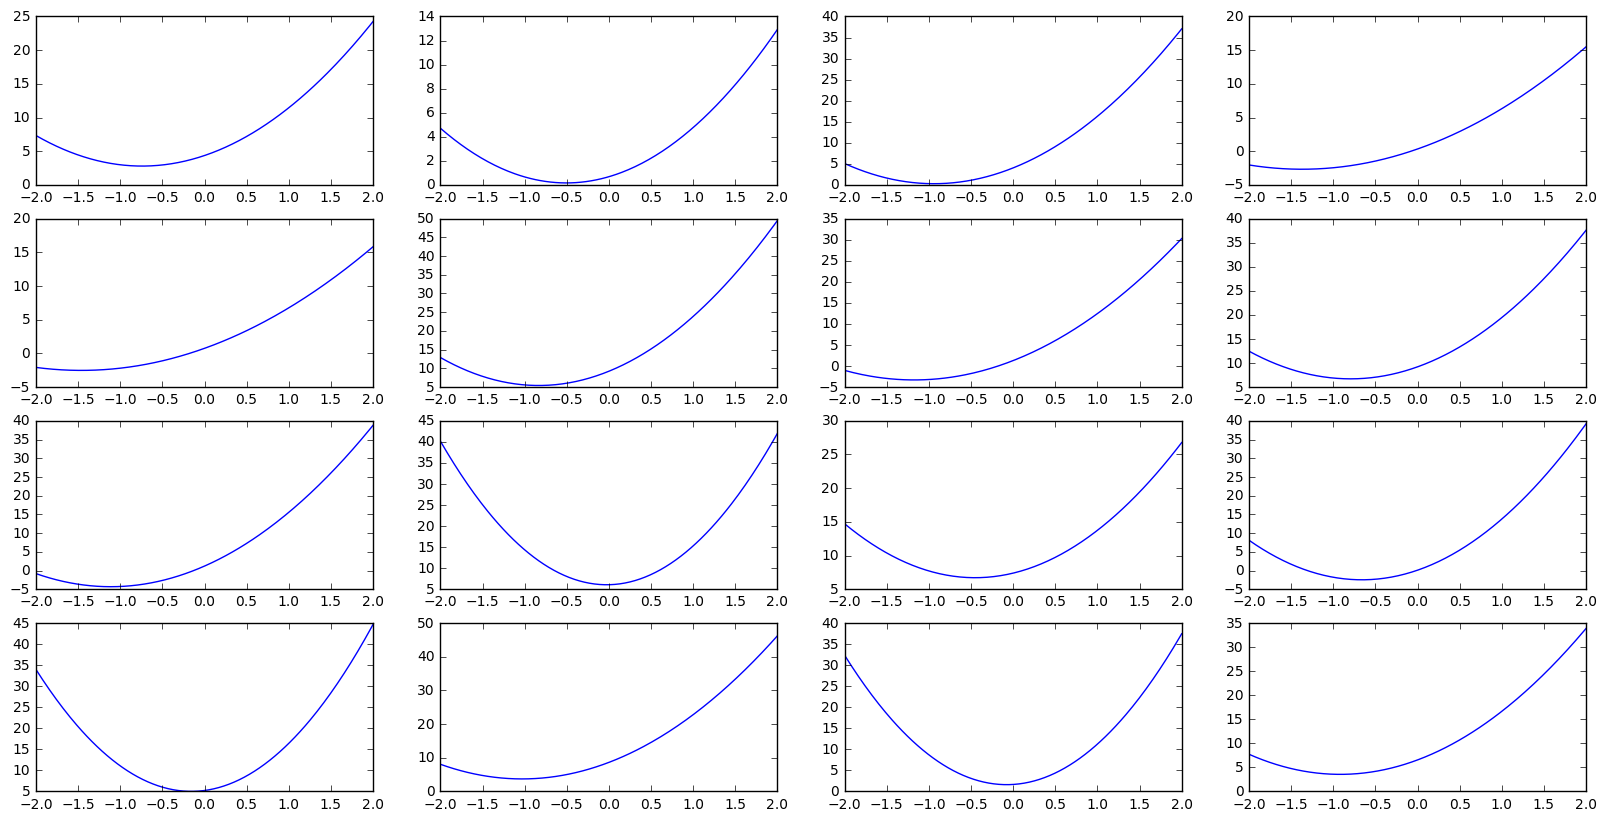

In [37]:
# visualize training data
plt.figure(figsize=(20,10))
for i in range(16):
    xx = np.linspace(-2,2,200)
    yy = poly2(f_train[i],xx)
    plt.subplot(4,4,1+i)
    plt.plot(xx,yy)
plt.show()

In [4]:
print(f_train.shape)
print(x_init.shape)

(100, 3)
(100, 1)


In [39]:
# Create Model

x_0 = tf.placeholder(tf.float32, shape=[None,1])
params = tf.placeholder(tf.float32, [None, degree])
h_0 = tf.placeholder(tf.float32, [None, n_hidden])

def rnn_cell(x,y,h):
    with tf.variable_scope('rnn_cell', reuse=True):
        W_1 = tf.Variable(tf.truncated_normal([2+n_hidden,60],stddev=0.5))
        b_1 = tf.Variable(tf.constant(0.1, shape=[60]))

        W_2 = tf.Variable(tf.truncated_normal([60,60],stddev=0.5))
        b_2 = tf.Variable(tf.constant(0.1, shape=[60]))

        W_3 = tf.Variable(tf.truncated_normal([60,1+n_hidden],stddev=0.5))
        b_3 = tf.Variable(tf.constant(0.1, shape=[1+n_hidden]))

        z = tf.concat(1,[x, y, h])

        h_1 = tf.tanh(tf.matmul(z, W_1) + b_1)
        h_2 = tf.tanh(tf.matmul(h_1, W_2) + b_2)
        out = tf.tanh(tf.matmul(h_2, W_3) + b_3)

        x_out, h_out = tf.split_v(value = out,size_splits=[1, n_hidden],split_dim=1)
    
    return x_out, h_out

seq_length = 8
sample_points = [x_0]

f = poly(params,x_0)

x, h = rnn_cell(x_0,f, h_0) 
f = poly(params,x)
sample_points += [x]

f_sum = tf.reduce_sum(f)/(seq_length)

for i in range(seq_length-1):
    x, h = rnn_cell(x,f, h) 
    f = poly(params,x)
    sample_points += [x]

    f_sum += tf.reduce_sum(f)/(seq_length)
    

In [40]:
train_step = tf.train.AdamOptimizer(0.001).minimize(f_sum)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

[<tf.Tensor 'gradients_1/rnn_cell_16/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_15/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_14/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_13/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_12/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_11/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_10/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/rnn_cell_9/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]


In [41]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [42]:
epochs = 5000

for i in range(epochs):
    sess.run(train_step, feed_dict={params:f_train, x_0:x_init, h_0:h_init})
    cost = sess.run([f_sum], feed_dict={params:f_train, x_0:x_init, h_0:h_init})
    if i% 500 == 0:
        print("Epoch: "+str(i)+" Minimum function value "+str(cost))
    

Epoch: 0 Minimum function value [817.51758]
Epoch: 500 Minimum function value [408.75055]
Epoch: 1000 Minimum function value [318.30045]
Epoch: 1500 Minimum function value [291.66263]
Epoch: 2000 Minimum function value [284.50394]
Epoch: 2500 Minimum function value [280.01923]
Epoch: 3000 Minimum function value [276.60495]
Epoch: 3500 Minimum function value [266.75217]
Epoch: 4000 Minimum function value [257.07932]
Epoch: 4500 Minimum function value [260.89374]


## Evaluate Training Performance

In [43]:
# Generate Test Data
f_train_eval = f_train[15].reshape(-1,3)
x_init_eval = x_init[15].reshape(-1,1)
h_init_eval = h_init[15].reshape(-1,n_hidden)

In [44]:
samp = sess.run([sample_points], feed_dict={params:f_train_eval, x_0:x_init_eval, h_0:h_init_eval})

In [45]:
xx = np.linspace(-2,2,100)
yy = poly2(f_train_eval,xx)

x_samples = np.array([float(x) for x in samp[0]])
y_samples = poly2(f_train_eval,x_samples)
annotation = np.linspace(0,seq_length,seq_length+1)

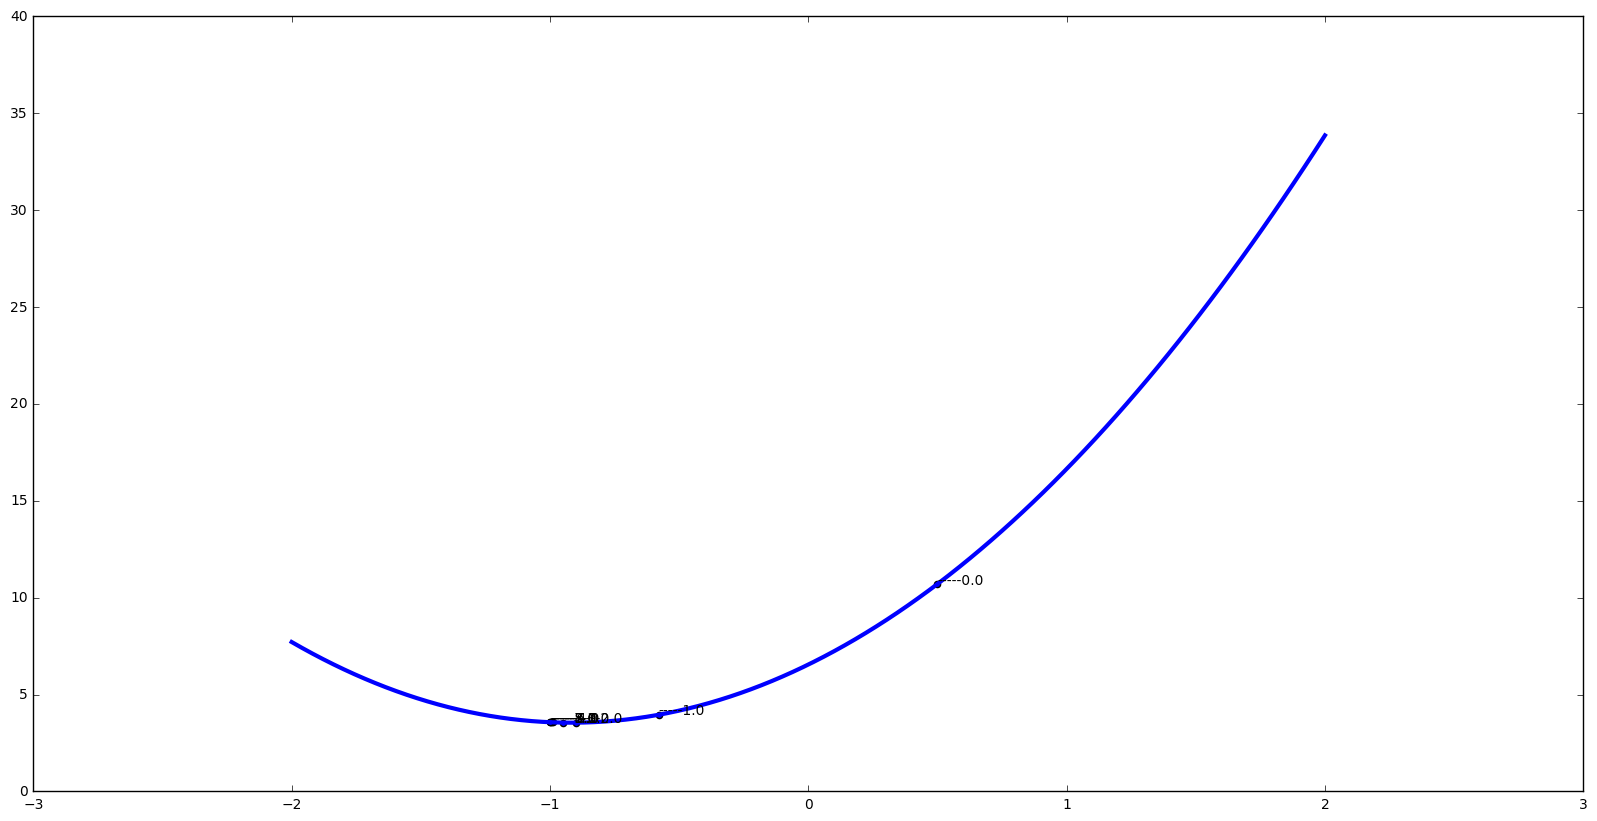

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hold(True)
ax.plot(xx,yy,linewidth=3)
ax.scatter(x_samples,y_samples)
for i, txt in enumerate(annotation):
    ax.annotate("-----"+str(txt), (x_samples[i],y_samples[i]))
plt.show()

## Evalutae Test performance

In [47]:
# Generate Test Data
f_test = 2*np.ones(3).reshape(-1,3)
x_init_test = 0.5*np.ones((n_test,1))
h_init_test = np.random.uniform(size=(n_test,n_hidden))

In [48]:
samp = sess.run([sample_points], feed_dict={params:f_test, x_0:x_init_test, h_0:h_init_test})

In [49]:
xx = np.linspace(-1,1,100)
yy = poly2(f_test,xx)

x_samples = np.array([float(x) for x in samp[0]])
y_samples = poly2(f_test,x_samples)
annotation = np.linspace(0,seq_length,seq_length+1)

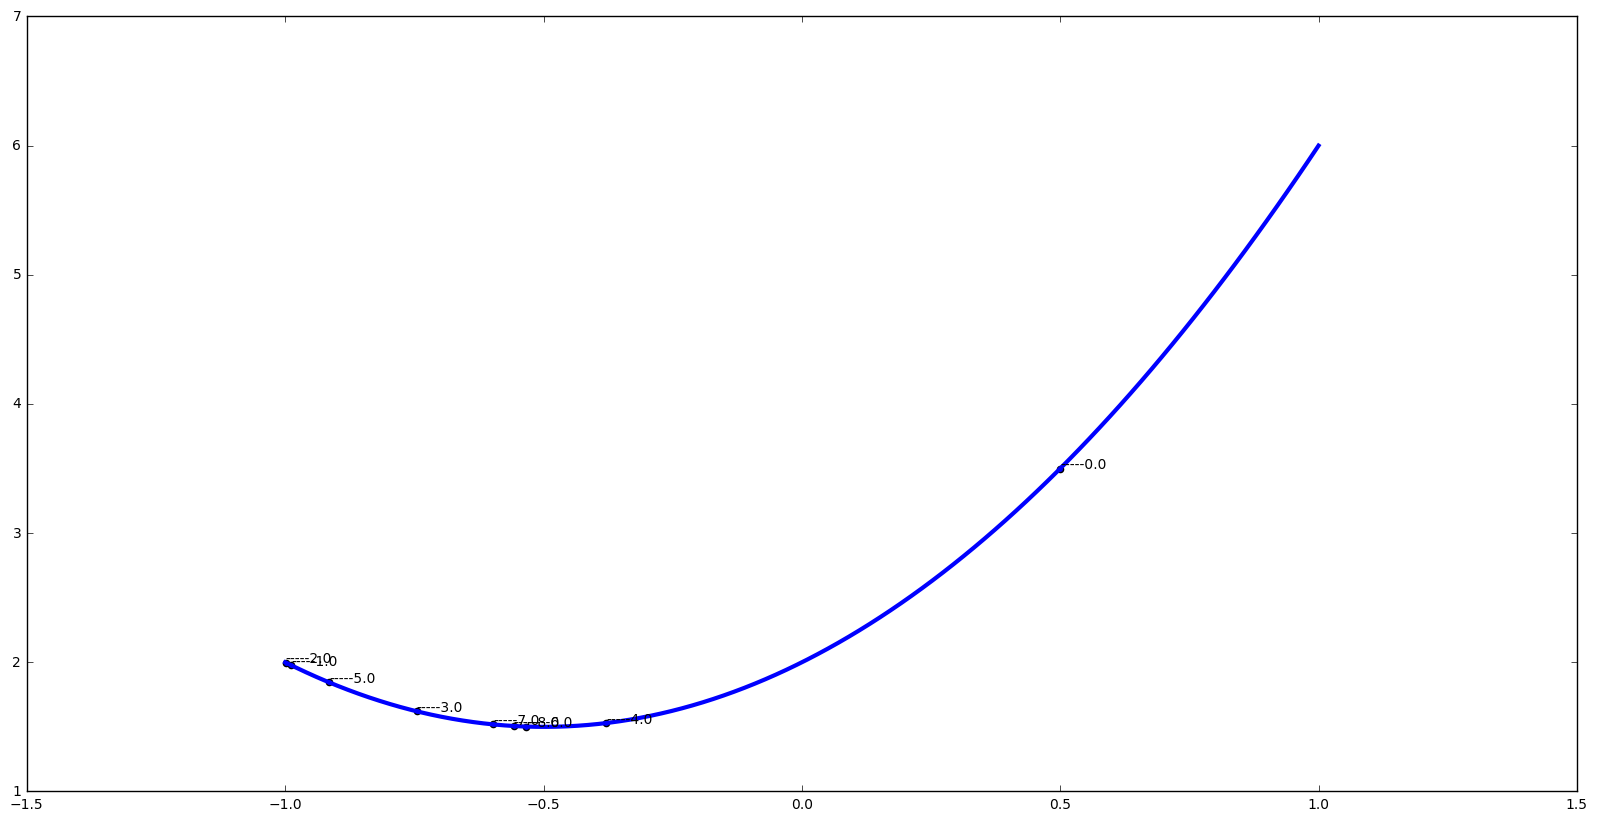

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hold(True)
ax.plot(xx,yy,linewidth=3)
ax.scatter(x_samples,y_samples)
for i, txt in enumerate(annotation):
    ax.annotate("-----"+str(txt), (x_samples[i],y_samples[i]))
plt.show()
